In [1]:
from utils import *
import array 

from pydub import AudioSegment
import tensorflow as tf

from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, Flatten, GlobalMaxPooling1D, MaxPooling2D, Activation, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPool2D, concatenate, Dense, Dropout
from keras.optimizers import Adam
from tensorflow.python.keras.utils import to_categorical

from keras.layers import Input, GRU, RepeatVector, BatchNormalization, TimeDistributed, Conv1D
from keras.layers import GlobalAveragePooling1D, LSTM, MaxPooling1D, CuDNNLSTM, Bidirectional
from keras import backend as K
from keras.layers import  Conv2D, MaxPooling2D, UpSampling2D, Lambda, Reshape
import keras
from keras.layers import AveragePooling1D

from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt


%matplotlib inline

Using TensorFlow backend.


In [2]:
POSSIBLE_LABELS = 'yes no up down left right on off stop go silence unknown'.split()
id2name = {i: name for i, name in enumerate(POSSIBLE_LABELS)}
name2id = {name: i for i, name in id2name.items()}
len(id2name)

12

In [3]:
%%time 

train_df = pickle.load( open("cache/train_df_256_aug.pik","rb"))
valid_df = pickle.load( open("cache/valid_df_256.pik","rb"))
silent_df = pickle.load(open("cache/silent_df_256.pik","rb"))
unknown_df = pickle.load(open("cache/unknown_df_256_aug.pik","rb"))


CPU times: user 14.8 s, sys: 21.5 s, total: 36.3 s
Wall time: 3min 41s


In [4]:
# test_df =  pickle.load(open("cache/test_df_256.pik","rb"))

In [5]:
train_df.reset_index(inplace=True)
valid_df.reset_index(inplace=True)
unknown_df.reset_index(inplace=True)
silent_df.reset_index(inplace=True)

In [34]:
#no augmentation since the auto encoder has already seen all the train AND test files 

def train_generator(train_batch_size):
    while True:
        
        this_train = train_df.groupby('label_id').apply(lambda x: x.sample(n = 2000))
        extra_data_size = int(this_train.shape[0]* 0.1)
        this_train = pd.concat([silent_df.sample(extra_data_size),
                                this_train,
                                unknown_df.sample(extra_data_size*2)],axis=0 )
        
        this_train.reset_index(drop=True,inplace=True)
        
        shuffled_ids = random.sample(range(this_train.shape[0]), this_train.shape[0])
        
        for start in range(0, len(shuffled_ids), train_batch_size):
            x_batch = []
            y_batch = []
            
            end = min(start + train_batch_size, len(shuffled_ids))
            i_train_batch = shuffled_ids[start:end]
            for i in i_train_batch:
                x_batch.append(this_train.loc[i,'raw'].T)
#                 x_batch.append(process_wav_file(this_train.iloc[i], augment=True).T)

                y_batch.append(this_train.label_id.values[i])
                
            x_batch = 1.- np.array(x_batch)/-80.
            y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            
            yield x_batch, y_batch

In [8]:
# %time t = next(train_generator(256))[0][0].T

In [35]:
def valid_generator(val_batch_size):
    while True:
        ids = list(range(valid_df.shape[0]))
        for start in range(0, len(ids), val_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + val_batch_size, len(ids))
            i_val_batch = ids[start:end]
            for i in i_val_batch:
                x_batch.append(valid_df.loc[i,'raw'].T)
                y_batch.append(valid_df.label_id.values[i])

            x_batch = 1.- np.array(x_batch)/-80.
            y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            yield x_batch, y_batch

In [8]:
t = next(valid_generator(64))
t[0].shape

(64, 32, 256)

In [122]:
test_preds = np.load("cache/predictions_frqmaxpool256_plus_longblend1.npy")

In [133]:
test_df["id"] = test_df.index.values
test_df.reset_index(inplace=True)

In [134]:
def test_pseudo_generator(test_batch_size):
#     this_test = test_df #.sample(int(train_df.shape[0]//5* 0.1))
#     this_test["id"] = this_test.index.values
    
#     this_test.reset_index(inplace=True)
    while True:

        shuffled_ids = random.sample(range(test_df.shape[0]), test_df.shape[0])

        for start in range(0, len(test_df), test_batch_size):
            x_batch = []
            y_batch = []

            end = min(start + test_batch_size, len(shuffled_ids))
            i_test_batch = shuffled_ids[start:end]

            for i in i_test_batch:
                x_batch.append(test_df.loc[i,'raw'].T)
    #                 x_batch.append(process_wav_file(this_train.iloc[i], augment=True).T)

                y_batch.append(test_preds[test_df.loc[i,'id']])

            x_batch = 1.- np.array(x_batch)/-80.
            y_batch = np.array(y_batch)

            yield x_batch, y_batch

In [135]:
class MixIterator(object):
    def __init__(self, iters):
        self.iters = iters
        self.multi = type(iters) is list

        self.N = 64 

    def reset(self):
        for it in self.iters: it.reset()

    def __iter__(self):
        return self

    def next(self, *args, **kwargs):

        nexts = [next(it) for it in self.iters]
        n0 = np.concatenate([n[0] for n in nexts])
        n1 = np.concatenate([n[1] for n in nexts])
        return (n0, n1)

In [136]:
mi = MixIterator([train_generator(50), test_pseudo_generator(14)])


In [31]:
valid_df.label_id.value_counts()

11    4221
1      270
3      264
0      261
2      260
9      260
10     257
6      257
7      256
5      256
4      247
8      246
Name: label_id, dtype: int64

In [130]:
%time t = next(test_pseudo_generator(64))

CPU times: user 60 ms, sys: 12 ms, total: 72 ms
Wall time: 66.4 ms


In [68]:
valid_df.loc[0,'raw'].shape

(256, 32)

In [131]:
t[0].shape

(64, 32, 128)

In [7]:
#a common practice is to choose a filter size in time which spans 2/3 o

### Model

In [11]:
p = 0.0


In [12]:
def batch_relu(x):
    x = BatchNormalization()(x)    
    x = Activation('relu')(x)
    
    return x 

In [11]:
p =0.
def get_1dconvs_maxpool_freq_deep( x_in, filter_size=2):
    
    x = BatchNormalization()(x_in)
    
    x = Conv1D(64,filter_size,activation='relu',padding='same')(x)
    x = Conv1D(64,filter_size,activation='relu',padding='same')(x)
    
    x = Dropout(p/2)(x)

    x = BatchNormalization()(x)
    x  = MaxPooling1D(2)(x)   

    
    x = Conv1D(128,filter_size,activation='relu',padding='same')(x)
    x = Conv1D(128,filter_size,activation='relu',padding='same')(x)

    x = Dropout(p/2)(x)
    
    
    x = BatchNormalization()(x)
    x  = MaxPooling1D(2)(x)   

    x = Conv1D(256,filter_size,activation='relu',padding='same')(x)
    x = Conv1D(256,filter_size,activation='relu',padding='same')(x)

    x = Dropout(p/2)(x)    
    
    
    x = BatchNormalization()(x)
    x  = MaxPooling1D(2)(x) 
    

    x = Conv1D(512,filter_size,activation='relu',padding='same')(x)
    x = Conv1D(512,filter_size,activation='relu',padding='same')(x)

    x = Dropout(p/2)(x)    
    
    
    x = BatchNormalization()(x)
    x  = AveragePooling1D(2)(x) 
    
    
    
    x_max = GlobalMaxPooling1D()(x)
#     x_avg = GlobalAveragePooling1D()(x)

#     x = concatenate([x_max,x_avg])
    
    return x_max

In [13]:

timesteps, input_dim , latent_dim = 32,256, 128

In [13]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [19]:
# p = 0.0
# filter_size = 10

# input_img = Input(shape=(timesteps, input_dim))  # adapt this if using `channels_first` image data format
# # x = Reshape((input_dim, timesteps))(input_img)

# x = BatchNormalization()(input_img)


# x = Conv1D(64,10,padding='same')(x)
# x = batch_relu(x)
# x = Conv1D(64,10,padding='same')(x)
# x = batch_relu(x)


# x = Dropout(p/2)(x)
# # x  = MaxPooling1D(2)(x)   



# x = Conv1D(64,3,padding='same')(x)
# x = batch_relu(x)
# x = Conv1D(64,3,padding='same')(x)
# x = batch_relu(x)

# x = Dropout(p/2)(x)    
# # x  = MaxPooling1D(2)(x) 

# x = Bidirectional(CuDNNLSTM(32,return_sequences=True))(x)
# encoded = TimeDistributed(Dense(64,activation='relu'),name='latent')(x)

# x = BatchNormalization()(encoded)

# x = Bidirectional(CuDNNLSTM(32,return_sequences=True))(x)
# x = TimeDistributed(Dense(64,activation='relu'))(x)

# x = BatchNormalization()(x)


# x = Conv1D(64,3,padding='same')(x)
# x = batch_relu(x)
# x = Conv1D(64,3,padding='same')(x)
# x = batch_relu(x)



# x = Conv1D(64,10,padding='same')(x)
# x = batch_relu(x)
# x = Conv1D(64,10,padding='same')(x)
# x = batch_relu(x)




# decoded = Conv1D(256,5, activation='sigmoid', padding='same')(x)
# # decoded  = Reshape((timesteps, input_dim))(decoded)

# autoencoder = Model(input_img, decoded)
# autoencoder.compile(optimizer=Adam(lr=1e-3), loss=root_mean_squared_error, metrics=['accuracy'])

In [20]:
# autoencoder.load_weights("./weights/ae_wtest_time1dconvs_plus_lstm_rmse_256.hdf5")

# # best 2dconv #ae_wtest_2dconvs_rmse_256.hdf5")

# for l in autoencoder.layers:
#     l.trainable = False

In [114]:

# x = Reshape((32,64,1))(autoencoder.get_layer("latent").output)
# x = Conv2D(64, (3, 3), padding='same')(autoencoder.get_layer("latent").output)
# x = batch_relu(x)

# x = MaxPooling2D((2,3),padding='same')(x)

# x = Conv2D(128, (3, 3),  padding='same')(x)
# x = batch_relu(x)


# # x = MaxPooling2D()(x)

# # x = Conv2D(256, (3, 3),  padding='same')(x)
# # x = batch_relu(x)
# # x = Conv2D(256, (3, 3), padding='same')(x)
# # x = batch_relu(x)

# # x = MaxPooling2D()(x)

# # x = Conv2D(512, (3, 3),  padding='same')(x)
# # x = batch_relu(x)
# # x = Conv2D(512, (3, 3), padding='same')(x)
# # x = batch_relu(x)

# x = AveragePooling2D((2,3))(x)
# ae_model =  GlobalMaxPool2D()(x)

In [14]:
p = 0.0


def get_1dconvs_maxpool_freq_deep_fixed( x_in, filter_size=2):
    
    x = BatchNormalization()(x_in)
    
    

    x = Conv1D(64,10,padding='same')(x)
    x = batch_relu(x)
    x = Conv1D(64,10,padding='same')(x)
    x = batch_relu(x)

    
    x = Dropout(p/2)(x)
    x  = MaxPooling1D(2)(x)   



    x = Conv1D(128,5,padding='same')(x)
    x = batch_relu(x)
    x = Conv1D(128,5,padding='same')(x)
    x = batch_relu(x)

    
    x = Dropout(p/2)(x)    
    x  = MaxPooling1D(2)(x) 
    

    x = Conv1D(256,3,padding='same')(x)
    x = batch_relu(x)
    x = Conv1D(256,3,padding='same')(x)
    x = batch_relu(x)
    
    x = Dropout(p/2)(x)    
    
    
    x = Conv1D(256,3,padding='same')(x)
    x = batch_relu(x)
    x = Conv1D(256,3,padding='same')(x)
    x = batch_relu(x)
    
    x = Dropout(p/2)(x) 
    
    x  = AveragePooling1D(2)(x) 
    
    
    
    x_max = GlobalMaxPooling1D(name="freqconv_feats")(x)
#     x_avg = GlobalAveragePooling1D()(x)

#     x = concatenate([x_max,x_avg])
    
    return x_max

In [15]:

def embedder(filter_size=2):
    v_input = Input(shape=( timesteps,input_dim))
#     x = BatchNormalization()(v_input)
    
    
#     x = Conv1D(64,filter_size,padding='same')(x)
#     x = batch_relu(x)
#     x = Conv1D(64,filter_size,padding='same')(x)
#     x = batch_relu(x)
    
    
#     x  = MaxPooling1D(2)(x)   

#     x = Conv1D(128,filter_size,padding='same')(x)
#     x = batch_relu(x)
#     x = Conv1D(128,filter_size,padding='same')(x)
#     x = batch_relu(x)
 
#     x  = AveragePooling1D(2)(x)   
    
# #     x = Bidirectional(CuDNNLSTM(128,return_sequences=False))(x)
# #     x = BatchNormalization()(x)
# #     x = Dense(128,activation='relu')(x)
    
#     x = GlobalMaxPooling1D()(x)
    x = BatchNormalization()(v_input)
    
    x = Conv1D(64,filter_size,padding='same')(x)
    x = batch_relu(x)
    x = Conv1D(64,filter_size,padding='same')(x)
    x = batch_relu(x)
    
    x = Conv1D(128,3,padding='same')(x)
    x = batch_relu(x)
    x = Conv1D(128,3,padding='same')(x)
    x = batch_relu(x)
       
    x = MaxPooling1D()(x)
    
    x = Conv1D(256,3,padding='same')(x)
    x = batch_relu(x)
    x = Bidirectional(CuDNNLSTM(128,return_sequences=False))(x)

    return Model(v_input, x)

In [16]:
embedding = embedder(5)


/home/ubuntu/anaconda2/lib/python2.7/site-packages/numexpr/cpuinfo.py:42: UserWarning: [Errno 12] Cannot allocate memory
  warnings.warn(str(e), UserWarning, stacklevel=stacklevel)


In [17]:
embedding.load_weights("weights/speaker_embedding_t2.hdf5")

In [45]:
for l in embedding.layers:
    l.trainable=False

In [46]:
embedding.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 256)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 256)           1024      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 64)            81984     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 64)            256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 64)            20544     
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 64)            256       
__________

In [58]:
# p = 0.3


x_logml = Input(shape=(timesteps, input_dim)) #1 channel, 99 time, 161 freqs # S : np.ndarray [shape=(n_mels, t)]
x_freq = Reshape((input_dim, timesteps))(x_logml)


# x_3 = get_conv_stacks(x_logml,2)
# x_5 = get_conv_stacks(x_logml,5)
# x_1 = max_timeconvs(x_logml,2)

# x_time = concatenate([x_1,x_2,x_3])

# x_3 = get_1dconvs_maxpool_residuals(x_freq)




# 0.86
# xf_2= get_1dconvs_maxpool_freq_deep(x_freq,2)
xf_5 = get_1dconvs_maxpool_freq_deep_fixed(x_freq,10)
# xf_10 = get_1dconvs_maxpool_freq_deep_shortcut(x_freq,10)

# x_freq = concatenate([xf_2,xf_5,xf_10])


# xf_2= get_1dconvs_maxpool_freq_deep_shortcut (x_freq,2)
# xf_5 = get_1dconvs_maxpool_freq_deep_shortcut(x_freq,5)
# xf_10 = get_1dconvs_maxpool_freq_deep_shortcut(x_freq,10)

# x_freq = concatenate([xf_2,xf_5,xf_10])

# x = concatenate([ae_model,xf_5])
# x_3 = get_1dconvs_maxpool_residuals(x_freq)
# latent = autoencoder.get_layer("latent").output
# latent = AveragePooling1D()(latent)
# latent = GlobalMaxPooling1D()(latent)
speaker_embedding = embedding(x_logml)

x = concatenate([xf_5,speaker_embedding])
x = Dense(128, activation = 'relu')(x) #
x = Dropout(0.3)(x)



x = Dense(len(POSSIBLE_LABELS), activation = 'softmax', name='targets')(x)




In [59]:

model = Model(inputs = x_logml, outputs = x)
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [60]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 32, 256)      0                                            
__________________________________________________________________________________________________
reshape_10 (Reshape)            (None, 256, 32)      0           input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 256, 32)      128         reshape_10[0][0]                 
__________________________________________________________________________________________________
conv1d_78 (Conv1D)              (None, 256, 64)      20544       batch_normalization_95[0][0]     
__________________________________________________________________________________________________
batch_norm

In [61]:
# model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])


In [62]:
from keras.callbacks import TensorBoard
exp_name = "freq10105533_max_wspeaker_embedding_timebased" #max_freqconvs_2510_avgshortcuts
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=5,
                           verbose=1),
             
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=3,
                               verbose=1,
                               epsilon=0.01,
                              min_lr=1e-5),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/{}.hdf5'.format(exp_name),
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min')
#              , TensorBoard(log_dir='./logs/logs_{}'.format(exp_name), histogram_freq=0, batch_size=64, write_graph=True)
            ]


one conv, one lstm, 128
Epoch 00029: 
461/461 [==============================] - 9s 20ms/step - loss: 0.2684 - acc: 0.9172 - val_loss: 0.1769 - val_acc: 0.9465


Epoch 34/100, 256
461/461 [==============================] - 10s 22ms/step - loss: 0.2585 - acc: 0.9220 - val_loss: 0.1716 - val_acc: 0.9458

Epoch 28/100, 128 (3 convs, 16,8,4)
461/461 [==============================] - 12s 27ms/step - loss: 0.2704 - acc: 0.9181 - val_loss: 0.1600 - val_acc: 0.9476


above lstm 64
Epoch 33/100
461/461 [==============================] - 14s 31ms/step - loss: 0.2349 - acc: 0.9271 - val_loss: 0.1589 - val_acc: 0.9484
lstm 128
Epoch 23/100
461/461 [==============================] - 14s 30ms/step - loss: 0.2068 - acc: 0.9349 - val_loss: 0.1487 - val_acc: 0.9535
above, dense 64
Epoch 34/100
461/461 [==============================] - 14s 30ms/step - loss: 0.1626 - acc: 0.9467 - val_loss: 0.1455 - val_acc: 0.9552
double lstm
Epoch 39/100
461/461 [==============================] - 18s 38ms/step - loss: 0.1516 - acc: 0.9497 - val_loss: 0.1462 - val_acc: 0.9565

bilstm
Epoch 23/100
461/461 [==============================] - 19s 41ms/step - loss: 0.1740 - acc: 0.9435 - val_loss: 0.1382 - val_acc: 0.9584

extra layers
Epoch 27/100
461/461 [==============================] - 21s 45ms/step - loss: 0.1681 - acc: 0.9451 - val_loss: 0.1474 - val_acc: 0.9577

shrinking filters
Epoch 42/100
461/461 [==============================] - 22s 47ms/step - loss: 0.1486 - acc: 0.9499 - val_loss: 0.1383 - val_acc: 0.9575

convs between 2 lstms 
Epoch 20/100
461/461 [==============================] - 44s 96ms/step - loss: 0.2450 - acc: 0.9212 - val_loss: 0.1574 - val_acc: 0.9515





Epoch 25/100
461/461 [==============================] - 23s 50ms/step - loss: 0.1748 - acc: 0.9426 - val_loss: 0.1267 - val_acc: 0.9617
Epoch 25/100 double lstm
461/461 [==============================] - 38s 82ms/step - loss: 0.1680 - acc: 0.9459 - val_loss: 0.1415 - val_acc: 0.9599


freqconv_deep_buggy?
Epoch 2/100
461/461 [==============================] - 46s 100ms/step - loss: 0.1698 - acc: 0.9460 - val_loss: 0.1111 - val_acc: 0.9644
Epoch 34/100_fixed..
461/461 [==============================] - 17s 38ms/step - loss: 0.1404 - acc: 0.9543 - val_loss: 0.1085 - val_acc: 0.9681
Epoch 27/100_fixed_extralayers
461/461 [==============================] - 30s 65ms/step - loss: 0.1244 - acc: 0.9589 - val_loss: 0.0972 - val_acc: 0.9721
Epoch 21/100 10 5 3..
461/461 [==============================] - 37s 80ms/step - loss: 0.1879 - acc: 0.9403 - val_loss: 0.1111 - val_acc: 0.9651
Epoch 27/100 - retry 10 10 3 3 ..
461/461 [==============================] - 36s 77ms/step - loss: 0.1601 - acc: 0.9486 - val_loss: 0.1068 - val_acc: 0.9690

Epoch 27/100_with_maxresiduals
461/461 [==============================] - 30s 66ms/step - loss: 0.2305 - acc: 0.9226 - val_loss: 0.1161 - val_acc: 0.9665
Epoch 45/100 (with lstm)
461/461 [==============================] - 44s 95ms/step - loss: 0.1339 - acc: 0.9561 - val_loss: 0.1117 - val_acc: 0.9654






with 2dconv ae base - frozen 
Epoch 31/100
461/461 [==============================] - 160s 347ms/step - loss: 0.1337 - acc: 0.9562 - val_loss: 0.1021 - val_acc: 0.9708

Epoch 6/100 - finetuned .. wtf (freq10_max_deep_cone_64_with_aebase_finetune)
461/461 [==============================] - 307s 665ms/step - loss: 0.1276 - acc: 0.9581 - val_loss: 0.1022 - val_acc: 0.9694


freq15155533_max_dense256
Epoch 27/100
461/461 [==============================] - 38s 82ms/step - loss: 0.1378 - acc: 0.9558 - val_loss: 0.1027 - val_acc: 0.9695

Epoch 16/100
461/461 [==============================] - 109s 237ms/step - loss: 0.1362 - acc: 0.9539 - val_loss: 0.1042 - val_acc: 0.9711

with lstm_ae,still in 0.1, 0.11 range




with speaker embedding - freq based (4x unk)
Epoch 18/100
461/461 [==============================] - 34s 73ms/step - loss: 0.1331 - acc: 0.9560 - val_loss: 0.0939 - val_acc: 0.9697

with speaker embedding -time based (2x unk) - worse than baseline
Epoch 16/100
329/329 [==============================] - 27s 83ms/step - loss: 0.2065 - acc: 0.9347 - val_loss: 0.1349 - val_acc: 0.9582

In [63]:
batch_size = 64

history = model.fit_generator(generator= train_generator(batch_size),
                              steps_per_epoch=train_df.shape[0]*(1./5)//batch_size,
                              epochs=100,
                              callbacks=callbacks,
                              validation_data=valid_generator(batch_size),
                              validation_steps=int(np.ceil(valid_df.shape[0]/batch_size)))

Epoch 1/100
329/329 [==============================] - 32s 99ms/step - loss: 1.3514 - acc: 0.5364 - val_loss: 0.7820 - val_acc: 0.7403
Epoch 2/100
 41/329 [==>...........................] - ETA: 21s - loss: 0.8808 - acc: 0.7096

KeyboardInterrupt: 

In [39]:
model.load_weights('./weights/{}.hdf5'.format(exp_name))

### valid evaluation

In [125]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

In [126]:
val_preds = model.predict_generator(valid_generator(64),steps=int(np.ceil(valid_df.shape[0]/64.)))
val_preds = np.argmax(val_preds,axis=1)

In [127]:
val_preds.shape

(7055,)

In [128]:
oe = OneHotEncoder()

In [129]:
y_true = oe.fit_transform(valid_df.label_id.values.reshape(-1, 1)).todense()



In [130]:
val_preds = oe.transform(val_preds.reshape(-1, 1)).todense()


In [45]:
c

In [108]:
augs= []
num_augs = 4
for i in range(num_augs):
    augs.append(model.predict_generator(valid_generator_aug(64),steps=int(np.ceil(valid_df.shape[0]/64.)),verbose=1))

111/111 [==============================] - 66s 591ms/step


In [110]:
augs.append(val_preds)

In [111]:
preds_aug1[:,0].shape

(7055,)

In [112]:
len(augs)

5

In [113]:
np.mean(augs,axis=0).shape

(7055, 12)

In [62]:
val_preds[:,0].shape

(7055, 1)

In [65]:
# np.corrcoef(preds_aug1[:,0],val_preds[:,0])

In [114]:
val_blend = np.mean(augs,axis=0) #np.mean([val_preds,preds_aug1],axis=0)
val_blend = np.argmax(val_blend,axis=1)
val_blend = oe.transform(val_blend.reshape(-1, 1)).todense()

In [115]:
val_blend

matrix([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

In [117]:
print classification_report(y_true,val_blend,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.95      0.96       261
         no       0.90      0.93      0.91       270
         up       0.91      0.94      0.93       260
       down       0.97      0.95      0.96       264
       left       0.96      0.98      0.97       247
      right       0.98      0.94      0.96       256
         on       0.91      0.94      0.93       257
        off       0.87      0.95      0.91       256
       stop       0.97      0.95      0.96       246
         go       0.92      0.89      0.91       260
    silence       1.00      1.00      1.00       257
    unknown       0.98      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [111]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.97      0.97      0.97       261
         no       0.93      0.93      0.93       270
         up       0.93      0.95      0.94       260
       down       0.95      0.97      0.96       264
       left       0.96      0.97      0.96       247
      right       0.96      0.97      0.96       256
         on       0.91      0.95      0.93       257
        off       0.91      0.98      0.94       256
       stop       0.98      0.94      0.96       246
         go       0.93      0.93      0.93       260
    silence       0.99      1.00      0.99       257
    unknown       0.99      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [132]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.97      0.97       261
         no       0.92      0.93      0.92       270
         up       0.93      0.95      0.94       260
       down       0.94      0.97      0.96       264
       left       0.95      0.97      0.96       247
      right       0.95      0.97      0.96       256
         on       0.94      0.95      0.95       257
        off       0.92      0.98      0.95       256
       stop       0.96      0.95      0.95       246
         go       0.93      0.93      0.93       260
    silence       0.99      1.00      0.99       257
    unknown       0.99      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [133]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.97      0.97       261
         no       0.92      0.93      0.92       270
         up       0.93      0.95      0.94       260
       down       0.94      0.97      0.96       264
       left       0.95      0.97      0.96       247
      right       0.95      0.97      0.96       256
         on       0.94      0.95      0.95       257
        off       0.92      0.98      0.95       256
       stop       0.96      0.95      0.95       246
         go       0.93      0.93      0.93       260
    silence       0.99      1.00      0.99       257
    unknown       0.99      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [113]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.97      0.97       261
         no       0.92      0.94      0.93       270
         up       0.89      0.93      0.91       260
       down       0.96      0.97      0.96       264
       left       0.95      0.99      0.97       247
      right       0.96      0.97      0.97       256
         on       0.91      0.95      0.93       257
        off       0.92      0.95      0.93       256
       stop       0.97      0.95      0.96       246
         go       0.93      0.93      0.93       260
    silence       0.99      1.00      0.99       257
    unknown       0.99      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [63]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.96      0.97       261
         no       0.91      0.94      0.92       270
         up       0.93      0.92      0.92       260
       down       0.93      0.97      0.95       264
       left       0.95      0.98      0.96       247
      right       0.95      0.95      0.95       256
         on       0.93      0.93      0.93       257
        off       0.87      0.95      0.91       256
       stop       0.96      0.94      0.95       246
         go       0.90      0.91      0.90       260
    silence       0.99      1.00      0.99       257
    unknown       0.98      0.97      0.98      4221

avg / total       0.96      0.96      0.96      7055



In [32]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.97      0.98       261
         no       0.91      0.93      0.92       270
         up       0.91      0.93      0.92       260
       down       0.97      0.95      0.96       264
       left       0.97      0.98      0.97       247
      right       0.97      0.94      0.96       256
         on       0.95      0.94      0.95       257
        off       0.94      0.96      0.95       256
       stop       0.97      0.91      0.94       246
         go       0.88      0.87      0.87       260
    silence       0.99      1.00      1.00       257
    unknown       0.98      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [176]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.96      0.97       261
         no       0.92      0.93      0.92       270
         up       0.83      0.95      0.89       260
       down       0.95      0.96      0.96       264
       left       0.95      0.98      0.97       247
      right       0.97      0.95      0.96       256
         on       0.94      0.94      0.94       257
        off       0.90      0.95      0.92       256
       stop       0.96      0.94      0.95       246
         go       0.92      0.92      0.92       260
    silence       1.00      1.00      1.00       257
    unknown       0.99      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [107]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.97      0.98       261
         no       0.89      0.92      0.90       270
         up       0.92      0.94      0.93       260
       down       0.96      0.97      0.96       264
       left       0.96      0.98      0.97       247
      right       0.97      0.97      0.97       256
         on       0.93      0.95      0.94       257
        off       0.92      0.97      0.94       256
       stop       0.97      0.94      0.96       246
         go       0.91      0.91      0.91       260
    silence       0.99      1.00      1.00       257
    unknown       0.99      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [78]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.96      0.97       261
         no       0.88      0.91      0.89       270
         up       0.86      0.95      0.90       260
       down       0.92      0.95      0.93       264
       left       0.94      0.98      0.96       247
      right       0.94      0.95      0.95       256
         on       0.83      0.94      0.88       257
        off       0.87      0.94      0.90       256
       stop       0.98      0.93      0.95       246
         go       0.80      0.90      0.85       260
    silence       0.95      1.00      0.98       257
    unknown       0.98      0.95      0.97      4221

avg / total       0.95      0.95      0.95      7055



In [41]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.96      0.97       261
         no       0.92      0.92      0.92       270
         up       0.93      0.93      0.93       260
       down       0.99      0.95      0.97       264
       left       0.98      0.97      0.97       247
      right       0.99      0.95      0.97       256
         on       0.97      0.92      0.95       257
        off       0.94      0.92      0.93       256
       stop       0.99      0.94      0.97       246
         go       0.95      0.88      0.92       260
    silence       0.97      1.00      0.98       257
    unknown       0.76      0.98      0.86       257

avg / total       0.95      0.94      0.94      3091



In [95]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.96      0.97       261
         no       0.92      0.94      0.93       270
         up       0.92      0.93      0.93       260
       down       0.98      0.94      0.96       264
       left       0.97      0.97      0.97       247
      right       0.95      0.96      0.96       256
         on       0.96      0.95      0.96       257
        off       0.94      0.92      0.93       256
       stop       1.00      0.94      0.97       246
         go       0.96      0.89      0.92       260
    silence       0.98      1.00      0.99       257
    unknown       0.82      0.95      0.88       257

avg / total       0.95      0.95      0.95      3091



In [19]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.95      0.97       261
         no       0.94      0.95      0.95       270
         up       0.92      0.95      0.93       260
       down       0.99      0.95      0.97       264
       left       0.97      0.96      0.96       247
      right       0.99      0.95      0.97       256
         on       0.99      0.92      0.95       257
        off       0.93      0.94      0.93       256
       stop       0.98      0.95      0.97       246
         go       0.94      0.90      0.92       260
    silence       0.99      1.00      1.00       257
    unknown       0.80      0.96      0.88       257

avg / total       0.95      0.95      0.95      3091



In [197]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       1.00      0.96      0.98       261
         no       0.91      0.94      0.93       270
         up       0.90      0.95      0.92       260
       down       0.99      0.94      0.96       264
       left       0.98      0.98      0.98       247
      right       0.98      0.96      0.97       256
         on       0.98      0.93      0.95       257
        off       0.93      0.93      0.93       256
       stop       0.96      0.93      0.95       246
         go       0.95      0.90      0.92       260
    silence       0.98      1.00      0.99       257
    unknown       0.82      0.94      0.87       257

avg / total       0.95      0.95      0.95      3091



### submission


In [53]:
test_paths = glob(os.path.join('./data/', 'test/audio/*wav'))

In [54]:
len(test_paths)

158538

In [121]:
test_df = pickle.load( open("cache/test_df_256.pik","rb"))


In [122]:
test_df.shape

(158538, 5)

In [123]:
def test_generator(test_batch_size,augment=False):
    while True:
        ids = list(range(test_df.shape[0]))
        
        for start in range(0, len(ids), test_batch_size):
            x_batch = []
            end = min(start + test_batch_size, len(ids))
            i_test_batch = ids[start:end]
#             this_paths = test_paths[start:end]
#             for x in this_paths:
            for i in i_test_batch:
            #WATCHOUT > NO AUG
#                 x_batch.append(process_wav_file(x).T) #,reshape=False,augment=augment,pval=0.5))
                x_batch.append(test_df.loc[i,'raw'].T)

            x_batch = np.array(x_batch)
            x_batch = 1.- np.array(x_batch)/-80.
            
            yield x_batch

In [124]:
predictions = model.predict_generator(test_generator(batch_size), int(np.ceil(len(test_paths)/float(batch_size))), verbose=1)

2478/2478 [==============================] - 42s 17ms/step


In [125]:
np.save("cache/predictions_{}.npy".format(exp_name),predictions)

In [55]:
predictions = np.load('cache/nn_massive_freq1d/predictions_freqconvs1d_3_10_142_0.15_73_7-0.089219957183.npy')

In [56]:
predictions.shape

(158538, 12)

#### blending

In [123]:
# predictions_pyramid_noaug = np.load('cache/predictions_pyramid_noaug.npy')
# predictions_model_with_ae_base_drp2_1 = np.load('cache/predictions_model_with_ae_base_drp2_1.npy')
blend1 = np.load('cache/predictions_blend_dilated_conv1d_timek123_n_freqk48_pseudo_mixtimefreq1ds_plus_samewithlstm_plus_aebased_conv2d_finetuned.npy')
# predictions_aebase_aug_drp3_finetune = np.load('cache/predictions_aebase_aug_drp3_finetune.npy')
# predictions_conv_n_lstm = np.load("cache/predictions_dilated_conv_n_lstm.npy")

In [124]:
blend2 = np.mean([predictions,
                       blend1], axis=0)


In [126]:
np.save("cache/predictions_{}.npy".format("frqmaxpool256_plus_longblend1"),blend2)

In [156]:
# num_aug = 2 
# for i in range(num_aug):
#     predictions +=  model.predict_generator(test_generator(64,augment=True), int(np.ceil(len(test_paths)/64.)), verbose=1)
    

# predictions = predictions/(num_aug + 1.0)

2477/2478 [============================>.] - ETA: 0s

#### class assignment

In [57]:
classes = np.argmax(predictions, axis=1)

In [58]:
classes.shape, len(test_paths)

((158538,), 158538)

(array([ 12582.,   6037.,   5315.,   6311.,   5686.,   6582.,   6293.,
          5509.,   5620.,  98603.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

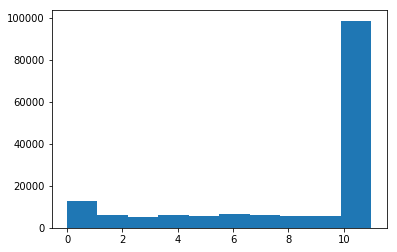

In [128]:
plt.hist(classes,bins=10)

(array([ 12814.,   5817.,   5536.,   6438.,   6017.,   6818.,   6597.,
          5552.,   5591.,  97358.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

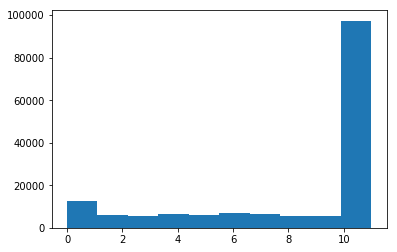

In [119]:
plt.hist(classes,bins=10)

(array([ 12794.,   6163.,   4986.,   6304.,   5482.,   6953.,   6442.,
          5801.,   5803.,  97810.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

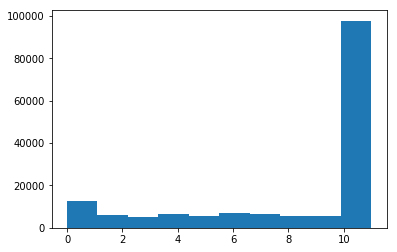

In [38]:
plt.hist(classes,bins=10)

(array([ 13314.,   6425.,   5008.,   5968.,   5353.,   7153.,   6788.,
          5934.,   6366.,  96229.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

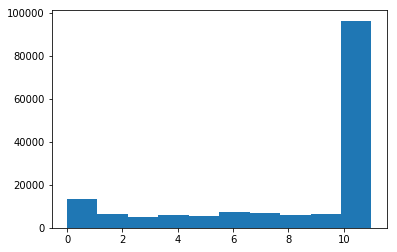

In [28]:
plt.hist(classes,bins=10)

(array([ 12750.,   6091.,   5142.,   6350.,   5542.,   6960.,   6424.,
          5745.,   6265.,  97269.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

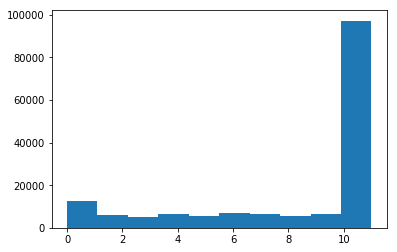

In [224]:
plt.hist(classes,bins=10)

(array([ 13344.,   6234.,   5208.,   6607.,   5785.,   7365.,   6680.,
          5825.,   6508.,  94982.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

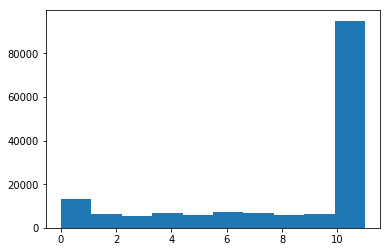

In [212]:
plt.hist(classes,bins=10)

### submission

In [59]:
### last batch will contain padding, so remove duplicates
submission = dict()
for i in range(len(test_paths)):
    fname, label = os.path.basename(test_paths[i]), id2name[classes[i]]
    submission[fname] = label

In [60]:
with open('subm/{}.csv'.format("bestof_freqconvs1d_3_10_142_0_0_08"), 'w') as fout: #_blend_conv1dlstm_and_aebased_conv2d_finetuned
    fout.write('fname,label\n')
    for fname, label in submission.items():
        fout.write('{},{}\n'.format(fname, label))

In [61]:
from IPython.lib.display import FileLink

FileLink('subm/{}.csv'.format("bestof_freqconvs1d_3_10_142_0_0_08"))


/home/ubuntu/keyword_spotting/subm/bestof_freqconvs1d_3_10_142_0_0_08.csv